In [70]:
import sys # for automation and parallelization: set manual to false when run by a launcher
import json
 
default = {'scenario': 'base','training_folder':'../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))

In [71]:
import sys, os
import time
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal

from quetzal.model import stepmodel
from syspy.syspy_utils.pandas_utils import groupby_weighted_average


In [72]:
scenario = argv['scenario']

output_folder = '../../scenarios/{scen}/outputs/'.format(scen = scenario)
filepath = '../../scenarios/{scen}/model/logit_assignment'.format(scen = scenario)
pro = stepmodel.read_zippedpickles(filepath)
filepath = '../../scenarios/{scen}/model/logit_assignment'.format(scen = scenario)
ref = stepmodel.read_zippedpickles(filepath)

zones: 100%|██████████| 38/38 [00:00<00:00, 189.79it/s]     


# Zones

## Part TC

In [73]:
def compute_vol(self):
    p = self.probabilities.set_index(['origin', 'destination', 'segment'])
    v = self.volumes.set_index(['origin', 'destination']).stack()   
    v.index.names = ['origin', 'destination', 'segment']

    return p.mul(v, axis=0).reset_index()

In [74]:
pro_vol_origin = compute_vol(pro).groupby('origin')[['car', 'pt']].sum()
ref_vol_origin = compute_vol(ref).groupby('origin')[['car', 'pt']].sum()

pro_share = pro_vol_origin.div(pro_vol_origin.sum(axis=1), axis=0)*100
ref_share = ref_vol_origin.div(ref_vol_origin.sum(axis=1), axis=0)*100

pro_share.columns = [c + '_share_pro' for c in pro_share.columns]
ref_share.columns = [c + '_share_ref' for c in ref_share.columns]

pro.zones = pro.zones.join(pro_share).join(ref_share)

pro.zones['car_share_diff'] = (pro.zones['car_share_pro'] - pro.zones['car_share_ref']).clip(upper=0)
pro.zones['pt_share_diff']  = (pro.zones['pt_share_pro']  - pro.zones['pt_share_ref']).clip(lower=0.0)
pro.zones['pt_share_diff_rel'] = (pro.zones['pt_share_diff']/pro.zones['pt_share_ref']).fillna(0.0)*100

<Axes: >

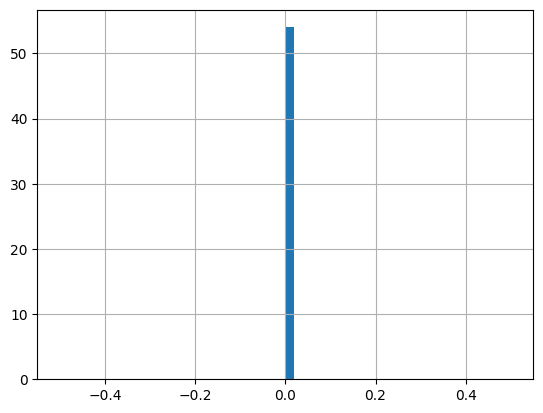

In [75]:
pro.zones['pt_share_diff'].hist(bins=50)

### PT Time Improvements

<Axes: >

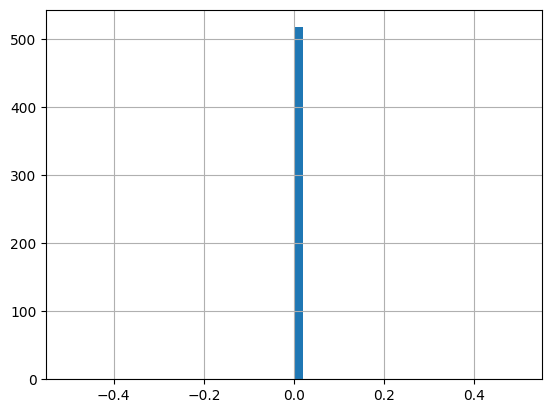

In [76]:
# Best pro time per OD
pro_min_time = pro.pt_los.sort_values('gtime').drop_duplicates(['origin', 'destination'])
pro_min_time = pro_min_time.set_index(['origin', 'destination'])['gtime']

# Best ref time per OD
ref_min_time = ref.pt_los.sort_values('gtime').drop_duplicates(['origin', 'destination'])
ref_min_time = ref_min_time.set_index(['origin', 'destination'])['gtime']

# Utility Improvement per OD
diff_time = (pro_min_time - ref_min_time).clip(upper=0)/60
diff_time.hist(bins=50)

In [77]:
v = pro.volumes.set_index(['origin', 'destination']).sum(axis=1)
v.name = 'volume'

time_improv = pd.concat([diff_time, v], axis=1)

time_impov_origin = groupby_weighted_average(time_improv.reset_index(), groupby='origin', columns='gtime', weight='volume')
time_impov_origin.rename(columns = {'gtime': 'time_improv'}, inplace=True)

pro.zones = pro.zones.join(time_impov_origin)

array([[<Axes: title={'center': 'time_improv'}>]], dtype=object)

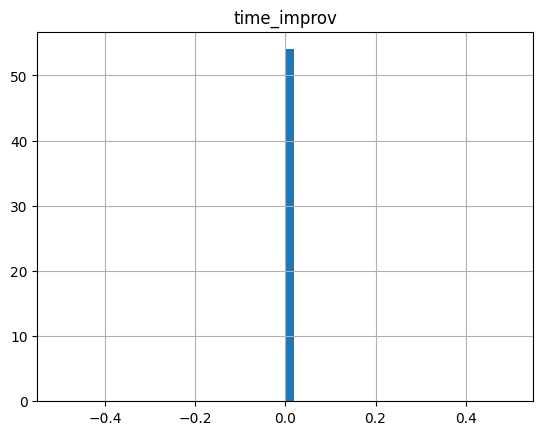

In [78]:
time_impov_origin.hist(bins=50)

In [87]:
self = pro.copy()
self.links['volume_tot'] = self.links['volume']
self.links.drop(columns='load', inplace=True, errors='ignore')
self.nodes.drop(columns='load', inplace=True, errors='ignore')
self.step_assignment(
    road = True,
    boardings=True,
    boarding_links=True,
    alightings=True,
    alighting_links=True,
    transfers=True,
)
self.links.rename(columns={'volume': 'load_tot'})
self.links.fillna(0.0, inplace=True)
self.nodes.fillna(0.0, inplace=True)

# Arboresence

In [88]:
links_set = set(pro.links[pro.links['agency_id'] == 'QUENEDI'].index)

In [89]:
self = pro.copy()

self.links.drop(columns='load', inplace=True,errors='ignore')
self.nodes.drop(columns='load', inplace=True,errors='ignore')
self.step_assignment(
    road = True,
    boardings=True,
    boarding_links=True,
    alightings=True,
    alighting_links=True,
    transfers=True,
)
self.links.rename(columns={'volume': 'load_tot'})
self.links.fillna(0.0, inplace=True)
self.nodes.fillna(0.0, inplace=True)
self.road_links.columns = [str(c) for c in self.road_links.columns]
self.road_links['load_tot'] =  self.road_links["('volume', 'pt')"] 
self.road_links.drop(columns=["('volume', 'pt')","('volume', 'car')"],inplace=True)


self.los['boarding_links'] = self.los['boarding_links'].apply(lambda d: d if isinstance(d, list) else [])
self.los = self.los[self.los['boarding_links'].apply(lambda x: len(set(x).intersection(links_set)) > 0)]

self.links.drop(columns='load', inplace=True,errors='ignore')
self.nodes.drop(columns='load', inplace=True,errors='ignore')
self.step_assignment(
    road = True,
    boardings=True,
    boarding_links=True,
    alightings=True,
    alighting_links=True,
    transfers=True,
)
self.links.rename(columns={'volume': 'load'})
self.links.fillna(0.0, inplace=True)
self.nodes.fillna(0.0, inplace=True)

In [90]:
assert self.links.loc[self.links['route_type'] != 'bus']['road_link_list'].apply(len).sum() == 0

In [91]:
self.links.loc[self.links['route_type'] == 'bus']['volume'].max()

0.0

In [92]:
road_links = self.road_links.copy()
road_links.columns=[str(c) for c in road_links.columns]
road_links['load'] = road_links["('volume', 'pt')"]
road_links.dropna(subset=['load_tot'], inplace=True)
road_links = gpd.GeoDataFrame(road_links, crs=pro.zones.crs).to_crs(epsg=4326)
#road_links.drop('index', axis=1).to_file(os.path.join(output_folder, 'road_links.geojson'))
road_links.to_file(os.path.join(output_folder, 'road_links.geojson'))

In [93]:
links = gpd.GeoDataFrame(self.links, crs=pro.zones.crs).to_crs(epsg=4326)
links.dropna(subset=['volume'], inplace=True)
links.drop('road_link_list', axis=1).to_file(os.path.join(output_folder, 'links_arbo.geojson'))

nodes = gpd.GeoDataFrame(self.nodes, crs=pro.zones.crs).to_crs(epsg=4326)
nodes.dropna(subset=['boardings', 'alightings'], how='all' , inplace=True)
nodes.to_file(os.path.join(output_folder, 'nodes_arbo.geojson'))

In [94]:
links = gpd.GeoDataFrame(pro.links, crs=pro.zones.crs).to_crs(epsg=4326)
links.dropna(subset=['load'], inplace=True)
links.drop('road_link_list', axis=1).to_file(os.path.join(output_folder, 'links.geojson'))

links = gpd.GeoDataFrame(pro.links, crs=pro.zones.crs).to_crs(epsg=4326)
nodes.dropna(subset=['boardings', 'alightings'], how='all', inplace=True)
nodes.to_file(os.path.join(output_folder, 'nodes.geojson'))

KeyError: ['load']

In [ ]:
zone = pro.zones.to_crs(epsg=4326)
zone['geometry'] = zone['geometry'].apply(lambda g: g.simplify(1e-3))
zone.to_crs(epsg=4326).to_file(os.path.join(output_folder, 'zones.geojson'))

In [ ]:
end_of_notebook